In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.23-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [2]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import h5py
import numpy as np
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tqdm import tqdm
import os
import cv2
import matplotlib.pyplot as plt

In [5]:
file = h5py.File('/content/drive/MyDrive/628/dataset.hdf5',mode = 'r')

In [6]:
x_train = file['x_train'][:]
y_train = file['y_train'][:]

In [7]:
x_val = file['x_val'][:]
y_val = file['y_val'][:]

In [8]:
x_test = file['x_test'][:]
y_test = file['y_test'][:]

In [9]:
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')


x_train/=255
x_val/=255
x_test /= 255

In [2]:
IR = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))

87916544/87910968 [==============================] - 35s 0us/step


In [3]:
for layer in IR.layers:
    layer.trainable = False

In [4]:
model = Sequential()
model.add(IR)
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation = 'sigmoid'))

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               26214912  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 48,018,209
Trainable params: 26,215,425
Non-trainable params: 21,802,784
_________________________________________________________________


In [6]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("/content/drive/My Drive/628/v2_weights.h5",monitor="val_accuracy",verbose=1,
                             save_best_only=True,
                             save_weights_only=True)
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,verbose=1)

In [16]:
history = model.fit(x_train,y_train, batch_size = 128, epochs = 100, validation_data=(x_val,y_val),shuffle = True,verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/100
57/57 [==============================] - ETA: 0s - loss: 3.4990 - accuracy: 0.9135
Epoch 00001: val_accuracy improved from -inf to 0.95833, saving model to /content/drive/My Drive/628/v2_weights.h5
57/57 [==============================] - 20s 359ms/step - loss: 3.4990 - accuracy: 0.9135 - val_loss: 0.8325 - val_accuracy: 0.9583
Epoch 2/100
57/57 [==============================] - ETA: 0s - loss: 0.3352 - accuracy: 0.9578
Epoch 00002: val_accuracy did not improve from 0.95833
57/57 [==============================] - 17s 305ms/step - loss: 0.3352 - accuracy: 0.9578 - val_loss: 0.1693 - val_accuracy: 0.9550
Epoch 3/100
57/57 [==============================] - ETA: 0s - loss: 0.0664 - accuracy: 0.9764
Epoch 00003: val_accuracy did not improve from 0.95833
57/57 [==============================] - 18s 310ms/step - loss: 0.0664 - accuracy: 0.9764 - val_loss: 0.1524 - val_accuracy: 0.9550
Epoch 4/100
57/57 [==============================] - ETA: 0s - loss: 0.0417 - accuracy: 0.9851

In [17]:
model.load_weights('/content/drive/My Drive/628/v2_weights.h5')

In [18]:
model.evaluate(x_test,y_test)

32/32 [==============================] - 2s 66ms/step - loss: 0.0965 - accuracy: 0.9760


[0.09648917615413666, 0.9760000109672546]

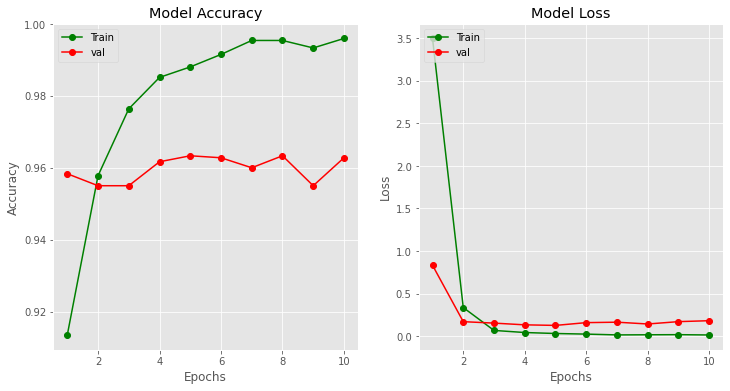

In [19]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1,len(history.history['accuracy'])+1)
plt.subplot(1,2,1)
plt.plot(epochs,history.history["accuracy"],"go-")
plt.plot(epochs,history.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

In [20]:
len(x_test)

1000

In [7]:
model.load_weights('/Users/xiaoshuaiheng/Desktop/EE 628 DeepLearning/final proj/v2_weights.h5')

In [19]:
test_dir = '/Users/xiaoshuaiheng/Desktop/EE 628 DeepLearning/final proj/dogs-vs-cats/test'
test_imageList =  os.listdir(test_dir)

In [20]:
len(test_imageList)

12500

In [21]:
res = []
dim_size = 224
for name in tqdm(test_imageList):
    image_path = test_dir + '/' + name
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image,(dim_size, dim_size))
    image = image.astype('float32')
    image/=255
    image = np.expand_dims(image, axis=0)
    score = model.predict(image)
    if score <= 0.5:
        label = 0
    else:
        label = 1
    res.append(label)

100%|██████████| 12500/12500 [15:14<00:00, 13.67it/s]


In [31]:
test_imageList[222][:-4]

'599'

In [37]:
id = []
for name in tqdm(test_imageList):
    id.append(int(name[:-4]))

100%|██████████| 12500/12500 [00:00<00:00, 1137604.96it/s]


In [33]:
import pandas as pd
df = pd.DataFrame()

In [39]:
df['id'] = id
df['label'] = res

In [47]:
df = df.sort_values(by='id')

In [49]:
df.head(20)

,id,label
11768,1,1
10969,2,1
11663,3,1
9385,4,1
10128,5,0
10928,6,0
10174,7,0
2365,8,0
3136,9,0
6223,10,0


In [50]:
save_path = '/Users/xiaoshuaiheng/Desktop/EE 628 DeepLearning/res.csv'
df.to_csv(save_path, header = True, index = False)